In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import os
import transformers as ppb
from transformers import RobertaModel, AutoConfig
import warnings
from sentence_transformers import SentenceTransformer
from torch.utils.tensorboard import SummaryWriter
warnings.filterwarnings('ignore')
from xclib.data.data_utils import read_sparse_file
import copy
from transformers import get_scheduler,AdamW
from transformers import AutoTokenizer
import nlpaug.augmenter.word as naw
import nlpaug
import nltk
import xclib.evaluation.xc_metrics as xc_metrics
import xclib.data.data_utils as data_utils
import matplotlib.pyplot as plt
import scipy.sparse as sp
from nns import exact_search
from model import *
from loader import *
from utils import *
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

results_dir = '/ecstorage/bert-opt/tb_logs/WordNetLabelLoadRandomMaskBiggest_0.995000gamma_1600bs'
# results_dir = '/ecstorage/bert-opt/tb_logs/bert'

datadir='/ecstorage/bert-opt/datasets'
datadir='%s/LF-AmazonTitles-131K'%datadir
# datadir='%s/LF-AmazonTitles-1.3M'%datadir
trn_X_Y = read_sparse_file('%s/trn_X_Y.txt'%datadir)
tst_X_Y = read_sparse_file('%s/tst_X_Y.txt'%datadir)
device = torch.device('cuda:0')
batch_size = 1600
gamma = 0.995

model = BERTModel(gamma = gamma).to(device)

prefetch_factor = 8 
num_workers = 4
pin_memory = False
train_dataloader = torch.utils.data.DataLoader(BertDataset(datadir=datadir,mapping=trn_X_Y,split='trn',device=device),num_workers=num_workers,prefetch_factor=prefetch_factor,batch_size=batch_size,drop_last=True,shuffle=True,collate_fn=collate_fn,pin_memory=pin_memory)
test_dataloader = torch.utils.data.DataLoader(BertDataset(datadir=datadir,mapping=tst_X_Y,split='tst',device=device),num_workers=num_workers,prefetch_factor=prefetch_factor,batch_size=batch_size,drop_last=True,shuffle=True,collate_fn=collate_fn,pin_memory=pin_memory)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/t-pbansal/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/t-pbansal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [34]:
model.load_state_dict(torch.load(os.path.join(results_dir,'checkpoint.pt')))
evaluator = PrecEvaluator(datadir, test_dataloader.dataset,device,100)

score,res,score_mat = evaluator.get_scores(model)
# score_bert,res_bert,score_mat_bert = evaluator.get_scores(model)

  0%|          | 0/2 [00:00<?, ?it/s]

Doing nns in 2 shards



  8%|▊         | 152/1895 [01:02<11:57,  2.43it/s]


 16%|█▌        | 303/1895 [02:05<10:59,  2.41it/s]


 24%|██▍       | 454/1895 [03:08<09:54,  2.42it/s]


 32%|███▏      | 605/1895 [04:11<08:56,  2.40it/s]


 40%|███▉      | 756/1895 [05:15<08:13,  2.31it/s]


 48%|████▊     | 907/1895 [06:20<07:02,  2.34it/s]


 56%|█████▌    | 1057/1895 [07:23<05:53,  2.37it/s]


 64%|██████▎   | 1205/1895 [08:27<04:58,  2.31it/s]


 71%|███████▏  | 1353/1895 [09:30<03:54,  2.31it/s]


 79%|███████▉  | 1501/1895 [10:33<02:47,  2.35it/s]


 87%|████████▋ | 1649/1895 [11:36<01:43,  2.38it/s]


 95%|█████████▍| 1797/1895 [12:39<00:42,  2.33it/s]


100%|██████████| 1895/1895 [13:21<00:00,  2.36it/s]


Total time, time per point : 801.79s, 0.8264 ms/pt


  8%|▊         | 152/1895 [00:20<03:50,  7.55it/s]


 16%|█▌        | 303/1895 [00:39<03:29,  7.59it/s]


 24%|██▍       | 454/1895 [00:59<03:08,  7.63it/s]


 32%|███▏      | 605/1895 [01:19<02:48,  7.66it/s]


 40%|███▉      | 756/1895 [01:39<02:27,  7.70it/s]


 48%|████▊     | 907/1895 [01:59<02:10,  7.58it/s]


 56%|█████▌    | 1057/1895 [02:19<01:52,  7.42it/s]


 64%|██████▎   | 1205/1895 [02:38<01:31,  7.57it/s]


 71%|███████▏  | 1353/1895 [02:58<01:12,  7.49it/s]


 79%|███████▉  | 1501/1895 [03:17<00:52,  7.51it/s]


 87%|████████▋ | 1649/1895 [03:37<00:32,  7.50it/s]


 95%|█████████▍| 1797/1895 [03:57<00:13,  7.48it/s]


100%|██████████| 1895/1895 [04:10<00:00,  7.57it/s]


Total time, time per point : 250.39s, 0.2581 ms/pt


100%|██████████| 2/2 [18:39<00:00, 559.82s/it]


Recall@100: 24.63


In [31]:
dict_ = torch.load('/ecstorage/bert-opt/datasets/ngame_scores/e-200|bs-1200-M1_state_dict.pt')
temp_dict = model.state_dict()
for x in temp_dict.keys():
    if (x[:7] == 'encoder'):
        temp_dict[x] = dict_['student_modules.0.module.transformer'+x[7:]]

        
model.load_state_dict(temp_dict)
evaluator = PrecEvaluator(datadir, test_dataloader.dataset,device,100)
score_ngame,res_ngame,score_mat_ngame = evaluator.get_scores(model)

  0%|          | 0/2 [00:00<?, ?it/s]

Doing nns in 2 shards



  8%|▊         | 152/1895 [01:03<12:03,  2.41it/s]


 16%|█▌        | 303/1895 [02:05<11:04,  2.39it/s]


 24%|██▍       | 454/1895 [03:07<09:51,  2.43it/s]


 34%|███▎      | 639/1895 [04:25<08:52,  2.36it/s]


 42%|████▏     | 790/1895 [05:28<07:45,  2.37it/s]


 50%|████▉     | 941/1895 [06:33<06:50,  2.32it/s]


 58%|█████▊    | 1091/1895 [07:36<05:42,  2.35it/s]


 65%|██████▌   | 1239/1895 [08:39<04:39,  2.35it/s]


 73%|███████▎  | 1387/1895 [09:42<03:38,  2.33it/s]


 81%|████████  | 1535/1895 [10:44<02:32,  2.36it/s]


 89%|████████▉ | 1683/1895 [11:47<01:30,  2.34it/s]


 97%|█████████▋| 1831/1895 [12:50<00:27,  2.36it/s]


100%|██████████| 1895/1895 [13:17<00:00,  2.38it/s]


Total time, time per point : 797.14s, 0.8216 ms/pt


  8%|▊         | 152/1895 [00:19<03:53,  7.48it/s]


 16%|█▌        | 303/1895 [00:39<03:26,  7.72it/s]


 24%|██▍       | 454/1895 [00:59<03:09,  7.60it/s]


 32%|███▏      | 605/1895 [01:19<02:51,  7.54it/s]


 40%|███▉      | 756/1895 [01:39<02:29,  7.61it/s]


 48%|████▊     | 907/1895 [01:59<02:10,  7.60it/s]


 56%|█████▌    | 1057/1895 [02:18<01:50,  7.59it/s]


 64%|██████▎   | 1205/1895 [02:38<01:30,  7.67it/s]


 71%|███████▏  | 1353/1895 [02:57<01:11,  7.58it/s]


 79%|███████▉  | 1501/1895 [03:17<00:52,  7.54it/s]


 87%|████████▋ | 1649/1895 [03:36<00:32,  7.57it/s]


 95%|█████████▍| 1797/1895 [03:56<00:12,  7.65it/s]


100%|██████████| 1895/1895 [04:09<00:00,  7.61it/s]


Total time, time per point : 249.11s, 0.2568 ms/pt


100%|██████████| 2/2 [18:52<00:00, 566.24s/it]


Recall@100: 27.16


In [21]:
score_mat_ngame = sp.load_npz('/ecstorage/bert-opt/datasets/ngame_scores/M1-sim_score_mat.npz')
res = evaluator.printacc(score_mat_ngame, X_Y=tst_X_Y.tocsc(), K=5)

In [22]:
res

,1,2,3,4,5
P,40.722364,33.886602,28.392232,24.047354,20.693143
nDCG,40.722364,41.678035,43.214563,44.620541,45.758536
PSP,38.389705,41.176868,43.946998,46.688870,49.135931
PSnDCG,38.389704,40.370217,42.246908,43.750226,44.847637


In [29]:
print ("Ours")
print (res)
print ('')
print ("BERT")
print (res_bert)
print ('')
print ("NGAME")
print (res_ngame)
print ('')

Ours
                1          2          3          4          5
P       27.828828  22.561649  18.811387  15.966923  13.873697
nDCG    27.828828  27.860716  28.855765  29.885000  30.820066
PSP     27.307417  28.563284  30.315877  32.322369  34.334667
PSnDCG  27.307418  28.161183  29.396555  30.532062  31.448498

BERT
                1          2          3          4          5
P       21.528535  17.007083  13.979555  11.829087  10.216487
nDCG    21.528535  21.066546  21.599512  22.330691  22.964795
PSP     21.763413  22.037728  23.090166  24.496815  25.929314
PSnDCG  21.763414  21.863128  22.636248  23.442955  24.105832

NGAME
                1          2          3          4          5
P       40.699373  33.886973  28.379130  24.028998  20.694775
nDCG    40.699375  41.673052  43.193918  44.594765  45.747006
PSP     38.380544  41.179568  43.923761  46.654410  49.138734
PSnDCG  38.380545  40.370435  42.231616  43.731472  44.840980



In [33]:
print ("Ours")
print (res)
print ('')
print ("BERT")
print (res_bert)
print ('')
print ("NGAME")
print (res_ngame)

Ours
                1          2          3          4          5
P       27.828828  22.561649  18.811387  15.966923  13.873697
nDCG    27.828828  27.860716  28.855765  29.885000  30.820066
PSP     27.307417  28.563284  30.315877  32.322369  34.334667
PSnDCG  27.307418  28.161183  29.396555  30.532062  31.448498

BERT
                1          2          3          4          5
P       21.528535  17.007083  13.979555  11.829087  10.216487
nDCG    21.528535  21.066546  21.599512  22.330691  22.964795
PSP     21.763413  22.037728  23.090166  24.496815  25.929314
PSnDCG  21.763414  21.863128  22.636248  23.442955  24.105832

NGAME
                1          2          3          4          5
P       26.101767  22.505274  19.810486  17.820852  16.302017
nDCG    26.101768  24.087122  22.685488  21.722926  21.049862
PSP     21.920754  21.519540  21.058566  20.713435  20.472164
PSnDCG  21.920754  21.669137  21.522522  21.488310  21.529941


In [2]:
lbl = pd.read_json(datadir+'/raw/lbl.json',lines=True)
trn = pd.read_json(datadir+'/raw/trn.json',lines=True)
tst = pd.read_json(datadir+'/raw/tst.json',lines=True)


In [9]:
score_mat_ngame = sp.load_npz('/ecstorage/bert-opt/ngame_scores/M1-sim_score_mat.npz')

In [69]:
import matplotlib.pyplot as plt
plt.hist()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f8c80ab8310> (for post_execute):


KeyboardInterrupt: 

In [87]:
print(np.where(np.array(tst_X_Y.tocsc().sum(axis=0))[0]<5)[0].shape)
print(np.where(np.array(tst_X_Y.tocsc().sum(axis=0))[0]<10)[0].shape)
print(np.where(np.array(tst_X_Y.tocsc().sum(axis=0))[0]<100)[0].shape)
print(np.where(np.array(tst_X_Y.tocsc().sum(axis=0))[0]<1000)[0].shape)

(120558,)
(128880,)
(131058,)
(131073,)


In [89]:
inv_propen = xc_metrics.compute_inv_propesity(trn_X_Y, 0.6, 2.6)

In [92]:
print(inv_propen.shape)
print(trn_X_Y.shape)


(131073,)
(294805, 131073)


In [4]:
length_titles = np.array([x.split(' ') for x in lbl['title']])
len_ = np.array([len(x) for x in length_titles])

In [60]:
length_titles[101395]

['Black',
 'and',
 'Silver',
 'Stereo',
 'Headset',
 'with',
 'On/Off',
 'Switch',
 'for',
 'Nokia',
 'E60',
 '/',
 'E61',
 '/',
 'E62',
 '/',
 'E70',
 '/',
 'N70',
 '/',
 'N71',
 '/',
 'N73',
 '/',
 'N80',
 '/',
 'N92',
 '/',
 'N93',
 '/',
 '3200',
 '/',
 '3205',
 '/',
 '3250',
 '/',
 '3587i',
 '/',
 '5100',
 '/',
 '5140i',
 '/',
 '6070',
 '/',
 '6100',
 '/',
 '6101',
 '/',
 '6102',
 '/',
 '6102i',
 '/',
 '6103',
 '/',
 '6111',
 '/',
 '6125',
 '/',
 '6131',
 '/',
 '6155i',
 '/',
 '6170',
 '/',
 '6225',
 '/',
 '6230',
 '/',
 '6233',
 '/',
 '6255i',
 '/',
 '6256i',
 '/',
 '6265i',
 '/',
 '6270',
 '/',
 '6280',
 '/',
 '6282',
 '/',
 '6585',
 '/',
 '6600',
 '/',
 '6610',
 '/',
 '6620',
 '/',
 '6682',
 '/',
 '6800',
 '/',
 '7210',
 '/',
 '7250i',
 '/',
 '7360',
 '/',
 '7370',
 '/',
 '9300',
 '/',
 '9500',
 '/',
 'VI-3155i',
 '[OEM]',
 'HS-23',
 'from',
 'Eforcity']

(array([ 5270., 10709., 13414., 14074., 14031., 13785., 12603., 10891.,
         8677.,  6864.,  5380.,  4100.,  3079.,  2140.,  1494.,  1115.,
          812.,   610.,   443.,  1582.]),
 array([ 1.  ,  1.95,  2.9 ,  3.85,  4.8 ,  5.75,  6.7 ,  7.65,  8.6 ,
         9.55, 10.5 , 11.45, 12.4 , 13.35, 14.3 , 15.25, 16.2 , 17.15,
        18.1 , 19.05, 20.  ]),
 <BarContainer object of 20 artists>)

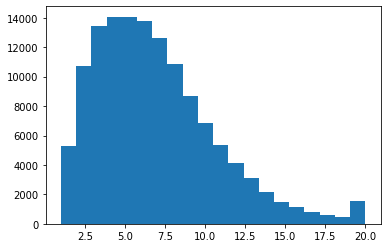

In [65]:
plt.hist(np.minimum(len_,20),bins=20)

In [68]:
print(np.where(len_>5)[0].shape)
print(np.where(len_<=5)[0].shape)

(73575,)
(57498,)


In [5]:
temp = np.fromfile('%s/tst_filter_labels.txt'%datadir, sep=' ').astype(int)
temp = temp.reshape(-1, 2).T
inv_propen = xc_metrics.compute_inv_propesity(read_sparse_file('%s/trn_X_Y.txt'%datadir), 0.6, 2.6)
filter_mat = sp.coo_matrix((np.ones(temp.shape[1]), (temp[0], temp[1])), read_sparse_file('%s/tst_X_Y.txt'%datadir).shape).tocsr()
long_labels = np.where(len_>5)[0]
short_labels = np.where(len_<=5)[0]

In [11]:
print(filter_mat.shape)
tst_X_Y.shape

(134835, 131073)


(134835, 131073)

In [9]:
# results_dir = '/ecstorage/bert-opt/tb_logs/WordNetLabelLoadRandomMaskBiggest_0.995000gamma_1600bs'
results_dir = '/ecstorage/bert-opt/tb_logs/bert'
score_mat_ngame = sp.load_npz('/ecstorage/bert-opt/datasets/ngame_scores/M1-sim_score_mat.npz')


model.load_state_dict(torch.load(os.path.join(results_dir,'checkpoint.pt')))

evaluator = PrecEvaluator(datadir, test_dataloader.dataset,device,inv_propen,filter_mat,100)
# score,res,score_mat = evaluator.get_scores(model)
score_bert,res_bert,score_mat_bert = evaluator.get_scores(model)


100%|██████████| 264/264 [00:14<00:00, 17.92it/s]


Total time, time per point : 14.74s, 0.1093 ms/pt
Recall@100: 42.83


In [10]:
print (score_mat.shape)
print (score_mat_bert.shape)
print (score_mat_ngame.shape)

(134835, 131073)
(134835, 131073)
(134835, 131073)


In [16]:
res

,1,2,3,4,5
P,27.828828,22.561649,18.811387,15.966923,13.873697
nDCG,27.828828,27.860716,28.855765,29.885000,30.820066
PSP,27.307417,28.563284,30.315877,32.322369,34.334667
PSnDCG,27.307418,28.161183,29.396555,30.532062,31.448498


In [15]:
def foo(score_mat,labels):
    res = evaluator.printacc(score_mat.tocsc()[:,labels], X_Y=tst_X_Y.tocsc()[:,labels], K=5)
    return res

print (foo(score_mat,long_labels))
print (foo(score_mat,short_labels))

print (foo(score_mat_ngame,long_labels))
print (foo(score_mat_ngame,short_labels))

print (foo(score_mat_bert,long_labels))
print (foo(score_mat_bert,short_labels))

                1          2          3          4          5
P       23.340379  18.504098  15.175832  12.724441  10.968072
nDCG    23.340379  24.163596  25.419497  26.416403  27.216792
PSP     31.017520  35.395430  39.324928  42.638454  45.564433
PSnDCG  31.017518  33.367139  35.481754  36.998570  38.146108
                1          2          3          4          5
P       11.625320   8.343160   6.547756   5.406423   4.597471
nDCG    11.625320  12.201147  12.824799  13.314627  13.647069
PSP     20.130152  20.957680  22.305018  23.787526  25.059356
PSnDCG  20.130153  21.811301  23.176698  24.146493  24.764107
                1          2          3          4          5
P       31.910112  24.866689  20.114708  16.622168  14.111173
nDCG    31.910113  33.106583  34.566441  35.618788  36.399466
PSP     42.396689  47.503247  52.079792  55.719311  58.709278
PSnDCG  42.396691  45.677286  48.226959  49.888161  51.040179
                1          2          3          4          5
P       

In [17]:
test_true = tst_X_Y.tocsc()
train_true = trn_X_Y.tocsc() 
test_pred = score_mat.tocsc()
test_pred_bert = score_mat_bert.tocsc()
test_pred_ngame = score_mat_ngame
random_locs = np.random.randint(131073,size=(100,))

import json
for index in range(100):
    print (">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    print ("Title")
    print (lbl.iloc[index]['title'])
    print ('')
    
    print ("Train GT")
    pred_labels = np.where(np.array(train_true[:,index].todense()) == 1)[0]
    print (trn['title'].iloc[pred_labels].tolist())
    print ('')

    print ("Test GT")
    pred_labels = np.where(np.array(test_true[:,index].todense()) == 1)[0]
    print (tst['title'].iloc[pred_labels].tolist())
    print ('')

    print ("Test Predicted (Ours)")
    pred_labels = np.array(test_pred[:,index].todense()).T.argsort()[0,-5:][::-1]
    print (tst.iloc[pred_labels]['title'].tolist())
    print ('')

    print ("Test Predicted (BERT)")
    pred_labels = np.array(test_pred_bert[:,index].todense()).T.argsort()[0,-5:][::-1]
    print (tst.iloc[pred_labels]['title'].tolist())
    print ('')
    
    print ("Test Predicted (NGAME)")
    pred_labels = np.array(test_pred_ngame[:,index].todense()).T.argsort()[0,-5:][::-1]
    print (tst.iloc[pred_labels]['title'].tolist())
    print ('')

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Title
Hundred Days

Train GT
['Hundred Days']

Test GT
['Post Captain']

Test Predicted (Ours)
['Two Thousand', 'Nine Lives', 'Ten Thousand Days', 'A Thousand Paths to Enlightenment', '...twenty-five...']

Test Predicted (BERT)
['Ten Thousand Days', 'Hundred Miles Off', 'Seventeen Days', 'The Last Days (1998)', 'A Hundred Miles or More: A Collection']

Test Predicted (NGAME)
['Ten Thousand Days', 'Hundred Miles Off', 'Into the Light', 'Sweet Mistakes', 'Nothing Comes Free']

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Title
Autumn Story Brambly Hedge

Train GT
['Summer Story (Brambly Hedge)']

Test GT
['Sea Story (Brambly Hedge)']

Test Predicted (Ours)
['Sea Story (Brambly Hedge)', 'Bramwell [VHS]', 'Bramwell - The Complete First Season', 'Sharon, Lois & Bram: One Elephant Went Out to Play [VHS]', 'Bath Squirters: Garden In Bag']

Test Predicted (BERT)
['Sea Story (Brambly Hedge)', 'East Au

['The Best of Mexico', 'The Best of France', 'Motorhead - The Best of Motorhead (2002)', "Lidia's Italy: Favorite Pastas! (Three-Disc Set)", 'Classic Albums - Motorhead: Ace of Spades']

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Title
Lemons: A Country Garden Cookbook

Train GT
['Summer Fruit: A Country Garden Cookbook', 'Luscious Lemon Desserts', 'Lemon Zest: More Than 175 Recipes with a Twist', 'Berries: A Country Garden Cookbook', 'Apples: A Country Garden Cookbook', 'Pears: A Country Garden Cookbook', 'Onions: A Country Garden Cookbook (Country Garden Cookbooks)', 'Herbs: A Country Garden Cookbook', 'Greens: A Country Garden Cookbook']

Test GT
['Potatoes: A Country Garden Cookbook', 'Tomatoes: A Country Garden Cookbook']

Test Predicted (Ours)
['Tomatoes: A Country Garden Cookbook', 'Potatoes: A Country Garden Cookbook', 'English Country Garden', 'The House & Garden Book of Country Rooms (House & Garden Series)', 'The Rescue (The English Garden Series #

["Jane's How to Fly and Fight in the F/A-18 Hornet (Jane's at the Controls)", 'F-15 Strike Eagle II', 'Skystreak, Skyrocket, & Stiletto: Douglas High-Speed X-Planes', 'Tomcat: The Definitive Guide', 'Space Harrier II']

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Title
Joseph [VHS] (1995)

Train GT
['Visual Bible: Gift of Spirit [VHS] (1994)', 'The Bible: In the Beginning... [VHS] (1966)', 'Abraham [VHS] (2001)', 'The Bible...In The Beginning [VHS] (1966)', 'Solomon [VHS] (2000)', 'The Bible: In the Beginning... [VHS] (1966)', 'The Bible - Esther [VHS] (2000)', 'Greatest Heroes of the Bible: Story of Noah [VHS] (1978)', 'Joseph [VHS] (1995)']

Test GT
['The Bible [VHS] (1966)', 'Bible & Robe [VHS]', 'Solomon [VHS]']

Test Predicted (Ours)
['Solomon [VHS]', 'Joseph: King of Dreams [VHS]', 'The Bible - Genesis [VHS] (1994)', 'The Passion of the Christ [VHS] (2004)', "Beginners Bible-The Story of Daniel and the Lion's Den: Children's Bible Story Video [VHS]"]

Te

["Boxing's Most Wanted(TM): The Top 10 Book of Champs, Chumps, and Punch-Drunk Palookas", 'Feng Shui for the Classroom: 101 Easy-to-Use Ideas', "Bonsai Boy's Professional Bonsai Soil - 2 lbs. (1 Qt.)", 'Boxing: The Complete Guide to Training and Fitness', 'The Modern Book of Feng Shui: Vitality and Harmony for the Home and Office']

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Title
PCOS Diet Book: How you can use the nutritional approach to deal with polycystic ovary syndrome

Train GT
['PCOS And Your Fertility', "A Patient's Guide to PCOS: Understanding--and Reversing--Polycystic Ovary Syndrome", 'New Glucose Revolution Guide to Living Well with PCOS', "What to Do When the Doctor Says It's PCOS: (Polycystic Ovarian Syndrome)"]

Test GT
["PCOS: A Woman's Guide to Dealing with Polycystic Ovary Syndrome"]

Test Predicted (Ours)
["PCOS: A Woman's Guide to Dealing with Polycystic Ovary Syndrome", 'Healing Syndrome O: A Strategic Guide to Fertility, Polycystic Ovar

['The Complete Book of Pasta and Noodles', 'Pomp And Sustenance: Twenty Five Centuries Of Sicilian Food', 'WMF Profi Plus Stainless Steel Cheese Plane', "In Nonna's Kitchen : Recipes and Traditions from Italy's Grandmothers", 'The Italian Baker']

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Title
Best American Poetry 1990

Train GT
['Best American Poetry 1990']

Test GT
['The Best American Poetry 1993']

Test Predicted (Ours)
['The Best American Poetry 1993', 'The Best American Poetry 1999', 'The Best American Poetry 2001', 'The Best American Poetry, 1989', 'The Best American Poetry 2006 (Best American Poetry)']

Test Predicted (BERT)
['The Best American Poetry, 1989', 'The Best American Poetry 1993', 'The Best American Poetry 1999', 'The Best American Poetry 2001', 'The Best American Poetry 2006 (Best American Poetry)']

Test Predicted (NGAME)
['The Best American Poetry 1993', 'The Best American Poetry, 1989', 'The Best American Poetry 2001', 'The Best Americ

['Selected writings', 'Introduction to the Philosophy of History', 'Emile Durkheim: Selected Writings', 'German Philosophers: Kant, Hegel, Schopenhauer, Nietzsche', "Hegel's Phenomenology: The Sociality of Reason"]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Title
Optimization in Operations Research

Train GT
['Optimization in Operations Research', 'AMPL: A Modeling Language for Mathematical Programming']

Test GT
['Java for Engineers and Scientists (2nd Edition)']

Test Predicted (Ours)
['Practical Methods of Optimization', 'Optimization by Vector Space Methods (Wiley Professional)', 'Engineering Optimization: Theory and Practice, 3rd Edition', 'Optimization: Foundations and Applications', 'Network Models in Optimization and Their Applications in Practice']

Test Predicted (BERT)
['Practical Methods of Optimization', 'Engineering Optimization: Theory and Practice, 3rd Edition', 'Optimization: Foundations and Applications', 'Genetic Algorithms in Search, Opti

['The New Southern Basics: Traditional Southern Food for Today', "Mrs. Whaley's Charleston Kitchen: Advice, Opinions, and 100 Recipes from a Southern Legend", "Mrs. Wilkes' Boardinghouse Cookbook: Recipes and Recollections from Her Savannah Table", "America's Great Delis: Recipes and Traditions from Coast to Coast", "Cooking Ladies' Recipes from the Road: Stovetop Creations and Travel Adventures"]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Title
You Gotta Have Wa: When Two Cultures Collide on the Baseball Diamond

Train GT
['You Gotta Have Wa: When Two Cultures Collide on the Baseball Diamond']

Test GT
['Sayonara Home Run!: The Art of the Japanese Baseball Card']

Test Predicted (Ours)
["Sarah's Long Walk: How the Free Blacks of Boston and their Struggle for Equality Changed America", 'Baseball Prospectus 2005: Statistics, Analysis, and Insight for the Information Age', 'In Other Worlds: Essays in Cultural Politics', 'Holding on: Dreamers, Visionaries, Ecce

['Vegetarian Times Low-Fat & Fast Mexican', 'Vegetarian Journal', 'Vegetarian Express : Easy, Tasty, and Healthy Menus in 28 Minutes(or Less!)', 'Chinese Cuisine: Szechwan Style', 'LIFE EXTENSION, TWO PER DAY - 120 VEGETARIAN TABLETS [Health and Beauty]']

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Title
Helping the Stork: The Choices and Challenges of Donor Insemination

Train GT
['Helping the Stork: The Choices and Challenges of Donor Insemination', 'Overcoming Male Infertility', 'Experiences of Donor Conception: Parents, Offspring and Donors through the Years', 'Having Your Baby Through Egg Donation']

Test GT
["Buying Dad: One Woman's Search for the Perfect Sperm Donor"]

Test Predicted (Ours)
["The Third Choice: A Woman's Guide to Placing a Child for Adoption", 'Remembering Home: Healing Hurts & Receiving Gifts from Conception to Birth', "Tomorrow's Baby: The Art and Science of Parenting from Conception through Infancy", 'Empty Womb, Aching Heart: Hope a

['English-Yiddish, Yiddish-English Dictionary: Romanized (Hippocrene Practical Dictionary)', 'English-Yiddish Yiddish-English Dictionary (Language Dictionaries Series)', 'English Yiddish Yiddish English Dictionary', 'The Meaning of Yiddish (Contraversions: Jews and Other Differenc)', 'Golijov: Yiddishbbuk']

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Title
The 15-Minute Gourmet: Vegetarian

Train GT
['The 15-minute Gourmet: Chicken', 'The 15-Minute Gourmet: Vegetarian', 'Vegetarian Sandwiches: Fresh Fillings for Slices, Pockets, Wraps, and Rolls']

Test GT
['The Spirited Vegetarian: Over 100 Recipes Made Lively with Wine and Spirits']

Test Predicted (Ours)
['The 15-Minute Single Gourmet: 100 Deliciously Simple Recipes for One', 'Gourmet Every Day: Over 200 Quick and Easy Recipes for Dinner', "Gourmet's Five Ingredients: More Than 175 Easy Recipes for Every Day", "The Vegetarian Gourmet's Easy Low-Fat Favorites", 'Frugal Gourmet: Fancy Chicken Dishes [VHS] (1